# Introduction

Welcome! This Jupyter notebook contains the Thursday's activity of the [NS3 Summer School](https://frib.msu.edu/public/frib-outreach/ns3.html). Two main topics will be addressed:

 1. Nuclear masses, binding energies and the impact of shell closures.
 2. The role of nuclear masses in the r-process path.
 
Throughout each section you will find questions and exercises (marked in red). Some of those are optional, and we suggest the groups to keep them for last.

## Tips:

 - If at some point you mess up something irreversibly, don't worry! Just click again in the [Binder link](https://mybinder.org/v2/gh/LaurenBalliet/NS3_2024.git/HEAD?labpath=notebook%2Fmasses.ipynb) and start a fresh notebook.
 - If working in Jupyter Lab, you can restart your notebook by clicking on `Kernel < Restart Kernel and Clear Outputs..`
 - If you need an empty Jupyter notebook, click on `File < New Notebook < Python 3`. 
 - You can run all the cells in the notebook by clicking  `Run < Run All Cells` in the menu above. It is convenient if you want to clean your variables after going back and forth between different cells.
 - You can also run individual cells by clicking the `Play` button on the upper left-hand side of the cell or pressing the `Shift` + `Enter` keys


## Contacts

 - Lauren Balliet: ballietl@frib.msu.edu
 - Fernando Montes: montes@frib.msu.edu

# Nuclear masses and the Liquid Drop Model (LDM)

## Bibliography
- The notes on the liquid drop model have been extracted from the [TALENT 2020 Machine Learning and Data Analysis course](http://github.com/NuclearTalent/MachineLearningECT). We are grateful to  Morten Hjorth-Jensen for sharing the source files.
- We highly recommend the [Wikipedia page](https://en.wikipedia.org/wiki/Semi-empirical_mass_formula) on liquid drop model, which contains an extensive and complete discussion about this topic.
- For those of you interested in deeper discussion about the physics contents of the liquid drop model parametrization, there is a recent paper on [Statistical aspects of nuclear mass models](https://iopscience.iop.org/article/10.1088/1361-6471/ab907c) by V. Kejzlar et al. ([here the arXiv version](https://arxiv.org/pdf/2002.04151.pdf)).

## Brief reminder on nuclear masses and binding energies

One of the most important observable of an atomic nucleus is its mass $M(Z, A)$, being $Z$ ($N$) the number of protons (neutrons) in the nucleus and $A=N+Z$ its mass number.

Atomic masses are usually tabulated in terms of the mass excess $\Delta M(N, Z)$

$$
\Delta M(N, Z) =  M(N, Z) - uA,
$$

where $u$ is the Atomic Mass Unit

$$
u = M(^{12}\mathrm{C})/12 = 931.4940954(57) \hspace{0.1cm} \mathrm{MeV}/c^2 \, .
$$

The nucleon masses are

$$
m_p =  1.00727646693(9)u = 938.27208(1) \hspace{0.1cm} \mathrm{MeV}/c^2\, ,
$$

and

$$
m_n = 1.0086649156(6)u = 939.56536(8)\hspace{0.1cm} \mathrm{MeV}/c^2 \, .
$$

The most recent and comprehensive collection of experimental data on nuclear masses 
and decays is the [2020 Atomic Mass Evaluation I (AME2020)](https://iopscience.iop.org/article/10.1088/1674-1137/abddb0/pdf) by W. J. Huang et al. and [2020 Atomic Mass Evaluation II (AME2020)](https://iopscience.iop.org/article/10.1088/1674-1137/abddaf/pdf)
by Meng Huang et al..   

The nuclear binding energy is defined as the energy required to break
up a given nucleus into its constituent parts of $N$ neutrons and $Z$
protons. In terms of the atomic masses $M(N, Z)$ the binding energy is
defined by

$$
BE(N, Z) = Zm_p c^2 + Nm_n c^2 - M(N, Z)c^2 \, .
$$

The plugging in for the atomic mass in terms of the mass excess, the binding energy can also be written as

$$
BE(N, Z) = Z\Delta m_p c^2 + N\Delta m_n c^2 - \Delta M(N, Z)c^2 \, .
$$

where the $uA$ terms cancel and $\Delta m_p c^2 = 7.2890$ MeV and $\Delta m_n c^2 = 8.0713$ MeV.


A popular and physically intuitive model which can be used to parametrize 
the experimental binding energies as function of $A$, is the so-called 
**liquid drop model (LDM)**. The ansatz is based on the following expression

$$
BE(N,Z) = a_1A-a_2A^{2/3}-a_3\frac{Z^2}{A^{1/3}}-a_4\frac{(N-Z)^2}{A} \, ,
$$

where $A$ is the number of nucleons and the $a_{i}$ terms are parameters determined by a fit 
to the experimental data.  




To arrive at the above expression we have concluded that we can make the following assumptions:

 * There is a **volume term** $a_1A$ proportional with the number of nucleons (the energy is also an extensive quantity). When an assembly of nucleons of the same size is packed together into the smallest volume, each interior nucleon has a certain number of other nucleons in contact with it. This contribution is proportional to the volume.

 * There is a **surface energy term** $a_2A^{2/3}$. The assumption here is that a nucleon at the surface of a nucleus interacts with fewer other nucleons than one in the interior of the nucleus and hence its binding energy is less. This surface energy term takes that into account and is therefore negative and is proportional to the surface area.

 * There is a **Coulomb energy term** $a_3\frac{Z^2}{A^{1/3}}$. The electric repulsion between each pair of protons in a nucleus yields less binding. 

 * There is an **asymmetry term** $a_4\frac{(N-Z)^2}{A}$. This term is associated with the Pauli exclusion principle and reflects the fact that the proton-neutron interaction is more attractive on the average than the neutron-neutron and proton-proton interactions.

### The AME 2020 data

Let us start with reading and organizing our data for the experimental masses and binding energies collected in the AME 2020 database and see how the masses look like as a function of the mass number $A$. Keep in mind that the for a proper scaling the binding energies listed in the AME 2020 database are divided by the number of nucleons $A$.

,N,Z,A,Element,Ebinding/A,Ebinding
0,2,3,5,Li,5.2661,26.3305
2,5,1,6,H,0.9616,5.7696
3,4,2,6,He,4.8785,29.2710
4,3,3,6,Li,5.3323,31.9938
5,2,4,6,Be,4.4872,26.9232
...,...,...,...,...,...,...
3398,157,108,265,Hs,7.2962,1933.4930
3405,158,108,266,Hs,7.2982,1941.3212
3406,157,109,266,Mt,7.2707,1934.0062
3426,159,110,269,Ds,7.2501,1950.2769


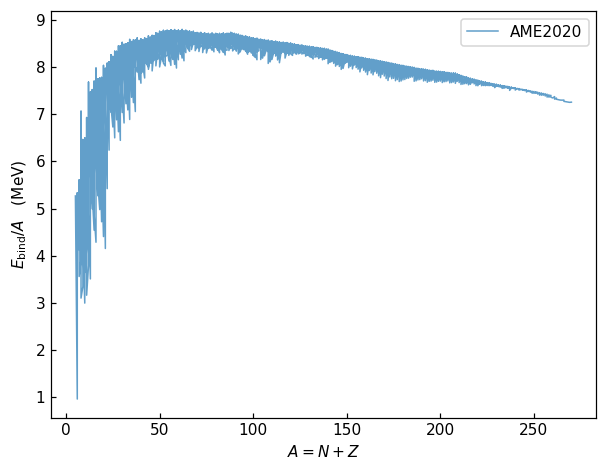

In [1]:
%reset -f
# 
# Import relevant libraries
#
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#
# Where to save the figures and data files
#
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/Plots"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

#
# File containing experimental masses
#
infile = open(data_path("MassEval2020.dat"),'r')


#
# Read the experimental data with Pandas
#
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding/A'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding/A'] = pd.to_numeric(Masses['Ebinding/A'].astype(str).str.split().str[-1],errors='coerce')
Masses = Masses.dropna()

# Convert from keV to MeV, and from energy per nucleon to energy
Masses['Ebinding/A'] /= 1000
Masses['Ebinding'] = Masses['Ebinding/A'] * Masses['A']
display(Masses)


#
# Let's plot the experimental binding energies per nucleon
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}/A \quad (\mathrm{MeV})$')
ax.plot(Masses['A'], Masses['Ebinding/A'], alpha=0.7, lw=1,
            label='AME2020')
ax.legend()
save_fig("Masses_AME2020")
plt.show()

As you can see, the binding energies (per nucleon) saturates at $A \sim 62$, in correspondence of the iron-nickel group. You can check this by running the cell below that determines the maximum binding energy value and its corresponding atomic mass number.

In [2]:
# finds the index of the maximum BE/A value
max_index = Masses['Ebinding/A'].idxmax()
# uses the index to determine the atomic mass of the max BE/A
print("atomic mass with maximum binding energy value:\n","A =",Masses['A'].loc[max_index])

atomic mass with maximum binding energy value:
 A = 62


<font color=red>
    
##  Questionnaire
    
 - Knowing that elements lighter than iron are created in stellar environments through fusion reactions, what is the implication of this saturation in binding energy on the nucleosynthesis of the elements heavier than iron
    
</font>

## LDM vs AME2020 experimental data

We can now use the experimental binding energies to fit the parameters of the liquid drop model, and we will do it by using the Scikit-Learn Python package. We will then compare the LDM predictions with the experimental data to study its systematic deviations.

Root-mean-square error: 3.71 MeV
Mean absolute error: 2.62 MeV
LDM coefficients (MeV): a_vo = 14.9494; a_su = -14.7277; a_co = -0.6694; a_sy = -21.7704 




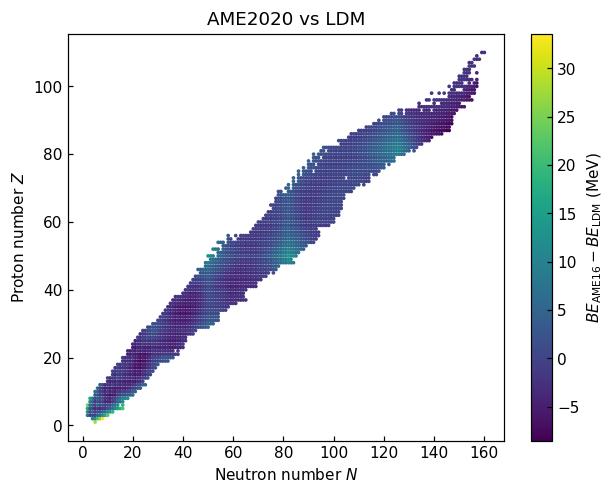

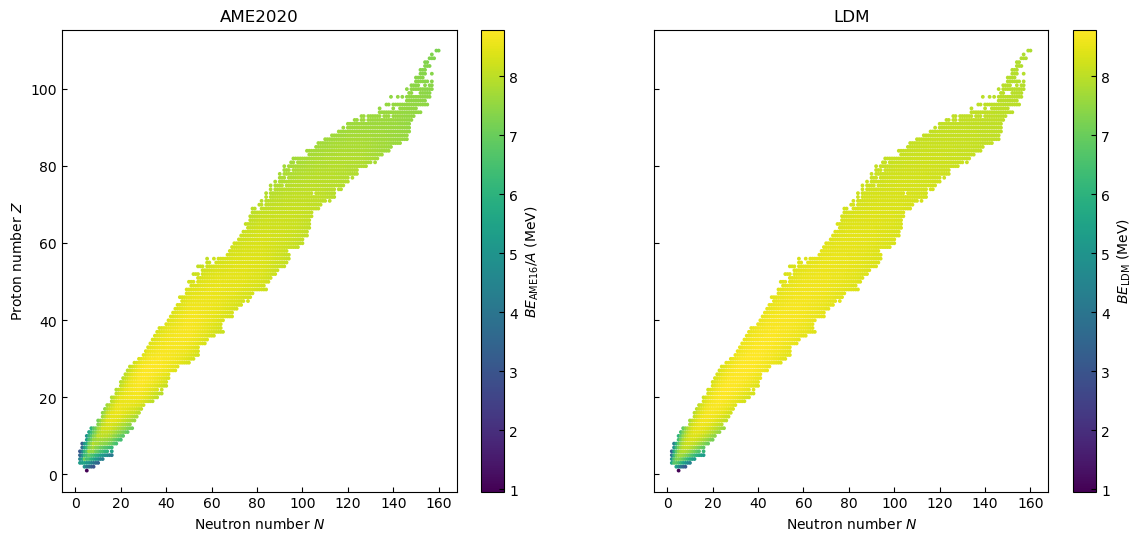

In [4]:
Masses_f = Masses.copy()

A = Masses_f['A']
Z = Masses_f['Z']
N = Masses_f['N']
Element = Masses_f['Element']
Energies = Masses_f['Ebinding']

#
# Now we set up the design matrix X used in our fitting procedure
#
X = np.zeros((len(A),5))
X[:,0] = 1
X[:,1] = A
X[:,2] = A**(2.0/3.0)
X[:,3] = Z**2*A**(-1.0/3.0)
X[:,4] = (N-Z)**2*A**(-1.0)

#
# Fit
#
lrg = skl.LinearRegression()
clf = lrg.fit(X, Energies) # or clf = skl.LinearRegression().fit(X, Energies)
fity = lrg.predict(X)
a_i = clf.coef_

#
# Statistics
#
# The mean squared error                               
print("Root-mean-square error: %.2f MeV" % np.sqrt(mean_squared_error(Energies, fity)))
# Mean absolute error                                                           
print('Mean absolute error: %.2f MeV' % mean_absolute_error(Energies, fity))
# LDM coefficients
print('LDM coefficients (MeV): a_vo = %.4f; a_su = %.4f; a_co = %.4f; a_sy = %.4f \n\n' %\
      (a_i[1], a_i[2], a_i[3], a_i[4]))

#
# Let's insert the result in the masses dataframe
#
Masses_f['Eapprox']  = fity
Masses_f['Residuals'] = Masses_f['Ebinding'] - Masses_f['Eapprox']
#display(Masses_f)

#
# Generate a plot comparing the experimental with the fitted values values
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'Neutron number $N$')
ax.set_ylabel(r'Proton number $Z$')
#ax.set_xlim(75, 100)
#ax.set_ylim(20, 100)
plt.title('AME2020 vs LDM')
plt.scatter(Masses_f['N'], Masses_f['Z'], s=2, marker='o', c=Masses_f['Residuals'], cmap='viridis')
plt.colorbar(label=r'$BE_\mathrm{AME16} - BE_\mathrm{LDM}$ (MeV)')
save_fig("AME2020vsLDM")
plt.show()

#
#Double plot comparing the AME 2020 and the LDM
#
fig, axv = plt.subplots(1, 2, sharex=True, sharey= True, figsize=(14, 6))
for ax in axv:
   ax.set_xlabel(r'Neutron number $N$')
axv[0].set_ylabel(r'Proton number $Z$')
axv[0].set_title('AME2020')
axv[1].set_title('LDM')
nz_eb = axv[0].scatter(Masses_f['N'], Masses_f['Z'], s=3, marker='o', c=Masses_f['Ebinding/A'])
nz_re = axv[1].scatter(Masses_f['N'], Masses_f['Z'], s=3, marker='o', c=(Masses_f['Eapprox']/Masses_f['A']))
fig.colorbar(nz_eb, ax=axv[0], label=r'$BE_\mathrm{AME16}/A$ (MeV)')
fig.colorbar(nz_eb, ax=axv[1], label=r'$BE_\mathrm{LDM}$ (MeV)')
save_fig("AME2020_and_LDM")
plt.show()



<font color=red>
    
##  Questionnaire
    
 - Given the plot of the binding energy differences between the AME2020 experimental data and the liquid-drop-model, could you identify which type of nuclei show the largest deviations? 

 - How does this relate with the quantum many-body nature of the nucleus? Which conclusions can be drawn regarding the liquid drop model (i.e., which physics is mostly missing in this model)?
    
</font>

<font color=red>
    
##  Try creating your own plots!
    
Insert a new cell below for a new workspace.

Suggestions:
    
 - the experimental binding energies per nucleon AME2020 (as above) with the estimated LDM binding energies overlayed
 - the residuals as a function of atomic mass, A (or neutron number, N or proton number, Z)
 - make something new to the nuclear chart
 - add extra details to previous plots like magic numbers
 - even changing the colors or setting new x and y limits on the axis is great practice!

</font>

## Neutron separation energies

To gain more insights about the limitations of the liquid-drop model, let us study the $Q$ values associated with the removal of one or two neutrons from a nucleus, which are conventionally defined in terms of the one-nucleon and two-nucleon separation energies:

\begin{eqnarray}
S_n &=& BE(N,Z) - BE(N - 1, Z) \, , \\
S_{2n} &=& BE(N,Z) - BE(N - 2, Z) \, . 
\end{eqnarray}

Using the previous binding energies, we will now compute the one- and two-neutron separation energies and compare the results predicted by the LDM with the AME2020 experimental data.

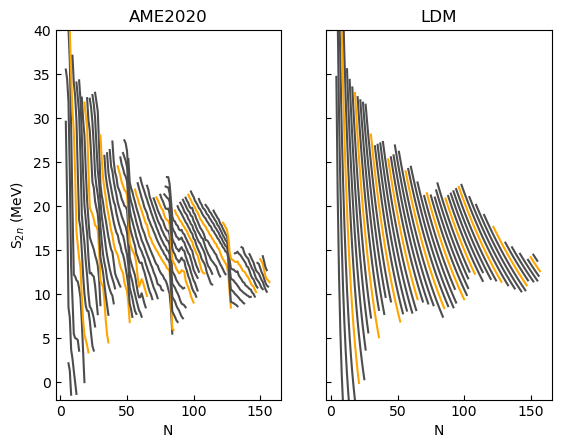

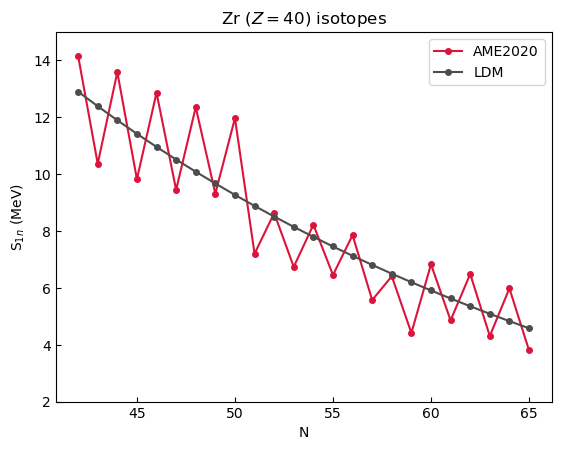

In [5]:
#
# Let's write a function to compute the neutron separation energies
#
def get_Sn(masses_df):
    """
    Function to compute neutron separation energies in masses_df 
    """
    # Sort dataframe as a function of Z and A
    masses_df.sort_values(['Z', 'A'], inplace=True)

    # Get neutron and proton separation energies
    masses_df['S1n'] = masses_df['Ebinding'].diff(1)
    masses_df['S2n'] = masses_df['Ebinding'].diff(2)
    masses_df['S1n_app'] = masses_df['Eapprox'].diff(1)
    masses_df['S2n_app'] = masses_df['Eapprox'].diff(2)

    # Remove separation energies from transitional nuclei
    cond_s1n = (masses_df['Z'].diff(1) != 0) | (masses_df['N'].diff(1) != 1)
    cond_s2n = (masses_df['Z'].diff(2) != 0) | (masses_df['N'].diff(2) != 2)
    masses_df.loc[cond_s1n, 'S1n'] = float('NaN')
    masses_df.loc[cond_s2n, 'S2n'] = float('NaN')
    masses_df.loc[cond_s1n, 'S1n_app'] = float('NaN')
    masses_df.loc[cond_s2n, 'S2n_app'] = float('NaN')
    
    return masses_df

#
# Compute S1n and S2n
#
Masses_f = get_Sn(Masses_f)

#
# Let's plot the 2-neutron separation energies from AME and LDM
#
fig, axv = plt.subplots(1, 2, sharex=True, sharey=True, dpi=100)
for i in Masses_f['Z'].unique():
    masses_iso = Masses_f.loc[Masses_f['Z'] == i]
    if i%10 == 0:
        color = 'orange'
    else:
        color = '0.3'
    if i%2 == 0:
        axv[0].plot(masses_iso['N'], masses_iso['S2n'], '-', c=color)
        axv[1].plot(masses_iso['N'], masses_iso['S2n_app'], '-', c=color)

plt.ylim(-2, 40)
axv[0].set_xlabel('N')
#axv[0].set_xlim(50,100)
axv[1].set_xlabel('N')
axv[0].set_ylabel('S$_{2n}$ (MeV)')
axv[0].set_title('AME2020')
axv[1].set_title('LDM')
plt.show()


#
# Let's plot the one-neutron separation energies from AME and LDM
#
fig = plt.figure(dpi=100)
for i in Masses_f['Z'].unique():
    masses_iso = Masses_f.loc[Masses_f['Z'] == i]
    if i == 40:
        plt.plot(masses_iso['N'], masses_iso['S1n'], '-o', c='crimson', ms=4, label='AME2020')
        plt.plot(masses_iso['N'], masses_iso['S1n_app'], '-o', c='0.3', ms=4, label='LDM')

plt.ylim(2, 15)
plt.xlabel('N')
plt.ylabel('S$_{1n}$ (MeV)')
plt.title('Zr ($Z=40$) isotopes')
plt.legend()
plt.show()

<font color=red>
    
##  Questionnaire
    
 - Looking at the plot of the two-neutron separation energies from AME2020 as a function of neutron number $N$, could you assess what is the impact of shell closure in this observable? 

 - Given the plot of the one-neutron separation energy of Zirconium isotopes, which experimental feature is missing in the liquid drop model? Relate this with the tendency of protons pairs and neutrons pairs to occur. Can you guess a modification of the liquid drop-model which will take account of this effect?
    
 - [Optional]: Try to implement the odd-even staggering term in the liquid-drop-model formula. (One possible solution is given in the the piece of code below: remove the first `#` from each line and run it to see the result).
</font>


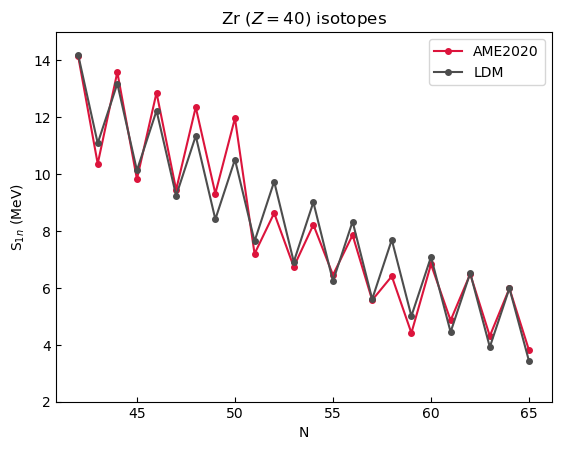

In [6]:
P = 1 - (N%2 + Z%2)
Masses_f['Eapprox'] = a_i[1]*A + a_i[2]*A**(2./3.) + a_i[3]*Z**2*A**(-1.0/3.0) + a_i[4]*(N-Z)**2/A  + 11.8/A**(1.0/2.0) * P

#
# Compute S1n and S2n
#
Masses_f = get_Sn(Masses_f)

###
### Let's plot the one-neutron separation energies from AME and LDM
###
fig = plt.figure(dpi=100)
for i in Masses_f['Z'].unique():
   masses_iso = Masses_f.loc[Masses_f['Z'] == i]
   if i == 40:
       plt.plot(masses_iso['N'], masses_iso['S1n'], '-o', c='crimson', ms=4, label='AME2020')
       plt.plot(masses_iso['N'], masses_iso['S1n_app'], '-o', c='0.3', ms=4, label='LDM')

plt.ylim(2, 15)
plt.xlabel('N')
plt.ylabel('S$_{1n}$ (MeV)')
plt.title('Zr ($Z=40$) isotopes')
plt.legend()
plt.show()

# The r-process path


## Bibliography
- The notes on network calculations are based on the [Phys. Rev. C83 045809 (2011)](https://link.aps.org/doi/10.1103/PhysRevC.83.045809) paper by A. Arcones and G. Martinez Pinedo ([here the arXiv version](https://arxiv.org/pdf/1008.3890.pdf)).
- In this section we will use theoretical masses calculated within the Density Functional theory. For those interested on more details about this quantum any-body method we recommend [the introductory review](http://link.springer.com/10.1140/epjp/i2018-12391-4) by G. Colo ([or its very similar arXiv version](http://arxiv.org/abs/1807.02643)).

## Introduction to reaction rates

Nuclear astrophysics deals with the description of reactions occurring in different astrophysical plasmas. Depending in the thermodynamic conditions characterizing the astrophysical scenario, different types of reactions such as fusion reactions, fission, photodisintegration, weak reactions and neutron capture processes can take place.

In general, given the reaction between a target $a$ and projectile $b$: 

$$
 a + b \longrightarrow c + d \,,
$$

the number of reactions per second, cm$^3$ and pair of reactants can be written as:

\begin{equation}
 r_{ab} = \lambda_{ab} n_a n_b \,,
 \label{eq:rab} \tag{1}
\end{equation}

being $n_i$ the number density of the species $i$ and $\lambda_{ab}$ the reaction rate, which is related to the energy dependent cross section of the reaction.

In case of a reaction with a massless projectile (e.g. photons) or a target much heavier that the projectile (e.g. electrons captured by nuclei), Eq. \eqref{eq:rab} can be rewritten as a function of an effective decay rate of the target:

\begin{equation}
 r_{ab} = \lambda_{b} n_b \,.
 \label{eq:rdecay}
\end{equation}

## Nuclear network calculations

The nucleosynthesis occurring in stellar environments can be simulated by large-scale nuclear network calculations. The general goal of such calculations is to study the temporal evolution of nuclear abundances $Y_i = n_i / n$, being $n_i$ the number density of species $i$ and $n \approx \rho / m_u$ the total number density of nucleons present in the environment. In this activity, we will explore the impact of nuclear masses in a specific nucleosynthesis process, the rapid-neutron capture process (or r-process).

In a simplified (yet realistic) description of the r-process, we can neglect charged particle reactions,
fission and alpha decays and assume that the evolution of the
nuclear abundances is determined only by three types of reactions:
 - Neutron captures $(n, \gamma)$: $^{A}Z + n \to ^{A+1}Z$.
 - Photodissociations $(\gamma, n)$: $^{A+1}Z + \gamma \to ^{A}Z + n$
 - Beta-decays: $ ^AZ \to ^A(Z+1)$.

Given such simplification, the change of the abundance of a nucleus with charge
$Z$ and mass number $A$ is given by the following differential equation:

\begin{eqnarray}
  \frac{d Y(Z,A)}{dt} & = & r_\textrm{creation} - r_\textrm{destruction} \nonumber \\
  & = &  \lambda_{(n,\gamma)}(Z, A-1) Y_n Y(Z,A-1) + 
  \lambda_{(\gamma, n)}(Z,A+1) Y(Z,A+1) + 
  \lambda_{\beta}(Z-1,A) Y(Z-1,A) \nonumber \\
  &  & - \left(\lambda_{(n,\gamma)}(Z, A) Y_n  +
    \lambda_{(\gamma, n)} (Z,A) + \lambda_{\beta}(Z, A)\right) Y(Z,A)
      \label{eq:yza} \tag{2}
\end{eqnarray}
where $Y_n$ is the neutron abundance and $\lambda_{i}(Z,A)$ is the reaction rate for a nucleus $^AZ$ and a reaction $i=\{(n,\gamma); (\gamma, i); \beta\}$. 

The neutron capture rate $\lambda_{(n,\gamma)}$ is usually expressed as a function of the velocity distribution averaged cross section 
$\langle \sigma v\rangle_{Z,A}$ and the baryon density $\rho$ as

\begin{equation*} 
    \lambda_{(n,\gamma)}(Z,A) = \rho N_A \langle \sigma v\rangle_{Z,A} \,,
\end{equation*}
and the photodissociation rate is related to the neutron capture rate by
**detailed balance**:

\begin{equation}
  \lambda_{(\gamma, n)}(Z,A+1) =  \langle\sigma v\rangle_{Z,A}
  \left(\frac{m_u k T}{2\pi\hbar^2}\right)^{3/2} \frac{2
    G(Z,A)}{G(Z,A+1)}\left(\frac{A}{A+1}\right)^{3/2}
  \exp \left[-\frac{S_n(Z,A+1)}{kT}\right],
  \label{eq:photonv} \tag{3}
\end{equation}
where $G$ is the partition function (which measures the internal degrees of freedom of the nucleus) and 
$S_n = m_n + M(Z,A-1)-M(Z,A)$ is the neutron separation energy with $m_n$ the
neutron mass and $M(Z,A)$ the mass of the nucleus.

Similarly to what we have done in Eq. \eqref{eq:yza}, we can write an expression for the evolution of neutron abundances (for simplicity, in all the equations we neglected the emission of neutron due to beta-decays):

\begin{equation}
  \frac{dY_n}{dt} = 
  - \sum_{Z,A} \rho N_A \langle \sigma v \rangle_{Z,A} Y_n Y(Z,A) 
  + \sum_{Z,A} \lambda_{\gamma} (Z,A) Y(Z,A)
  \label{eq:dyn} \tag{4}
\end{equation}


### The $(n,\gamma)\rightleftarrows(\gamma,n)$ equilibrium
The system of differential equations defined by
Eq. \eqref{eq:yza} and \eqref{eq:dyn} allows for several
approximations that are valid in different physical regimes. A
commonly used assumption in classical r-process calculations is the
$(n,\gamma)\rightleftarrows(\gamma,n)$ equilibrium. This approximation
is valid whenever the neutron density ($N_n = \rho N_A Y_n \gtrsim
10^{20}$ cm$^{-3}$) and temperature ($T\gtrsim
1$ GK) are large enough to warrant
that both the rate of neutron capture ($\lambda_{n, \gamma}$)
and the photodissociation rate ($\lambda_{\gamma, n}$) are much larger than
the beta decay rate ($\lambda_\beta$) for all the nuclei participating
in the network. Under this conditions the evolution of the system is
mainly determined by the beta decay rates as the abundances along an
isotopic chain are immediately adjusted to an equilibrium between
neutron captures and photodissociations, i.e.

\begin{equation}
    N_n Y(Z,A)
    \langle\sigma v\rangle_{Z,A} = \lambda_\gamma(Z,A+1)
    Y(Z,A+1)
   \label{eq:ngeq} \tag{5}
\end{equation}

Combining this result with Eq. \eqref{eq:photonv} one
obtains that the abundances in an isotopic chain are given by the
simple relation:

\begin{equation}
  \frac{Y(Z,A+1)}{Y(Z,A)} = N_n\left(\frac{2\pi\hbar^2}{m_ukT}\right)^{3/2}
  \left(\frac{A+1}{A}\right)^{3/2}\frac{G(Z,A+1)}{2G(Z,A)}
  \exp\left[\frac{S_n(Z,A+1)}{kT}\right].
  \label{eq:yequiv} \tag{6}
\end{equation}
For each isotopic chain, the above equation defines a nucleus that has
the maximum abundance and which is normally known as waiting point
nucleus as the flow of neutron captures "waits" for this nucleus to
beta-decay. The set of waiting point nuclei constitutes the r-process
path. The maximum of the abundance distribution can be determined
setting the left-hand side of Eq. \eqref{eq:yequiv} to 1, which
results in a value of $S_n$ that is the same for all isotopic chains
for a given neutron density and temperature:

\begin{equation}
  S^0_n (\text{MeV}) = \frac{T_9}{5.04} \left(34.075 - \log N_n +
    \frac{3}{2} \log T_9 \right),    
  \label{eq:sneq} \tag{7}
\end{equation}
where $T_9$ is the temperature in units of $10^9$ K and $N_n$ is the
neutron density in cm$^{-3}$. Equation \eqref{eq:sneq} implies that
the r-process proceeds along lines of constant neutron separation
energies towards heavy nuclei. For typical r-process conditions this
corresponds to $S^0_n \sim $2--3 MeV.

<font color=red>
    
##  Questionnaire
    
 - Recall the $S_{n}$ odd-even staggering that we observed in the AME2020 experimental dataset. In the light of this phenomenon, deduce whether the most abundant isotopes for a given $Z$ will have an even or odd neutron number $N$. 
    
 - [Optional] Given the detailed balance equation and the assuming $(n,\gamma)\rightleftarrows(\gamma,n)$ equilibrium, deduce the $S_n^0$ expression.
    
</font>

## Separation energies and r-process path

In the section above we deduced that for particular astrophysical conditions we can identify the r-process "waiting points" by looking at the neutron separation energies. The ensemble of these waiting points constitute the so-called r-process path. In this section, we will exploit this feature to calculate the r-process path predicted by different nuclear models. 

We will compare the results obtained with two different nuclear models. One is the familiar **liquid-drop-model** that we studied in the precious section. The second one will be a more realistic model based on the **density functional theory**, a popular quantum many-body method widely used in calculations across the whole nuclear chart.

For this exercise, we will use the nuclear masses predicted by the [UNEDF1](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.85.024304) Skyrme parametrization, that can be downloaded from the [Mass Explorer website](http://massexplorer.frib.msu.edu/).

/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Masses_th = pd.read_csv(infileth, usecols=(1,2,3,0,4),


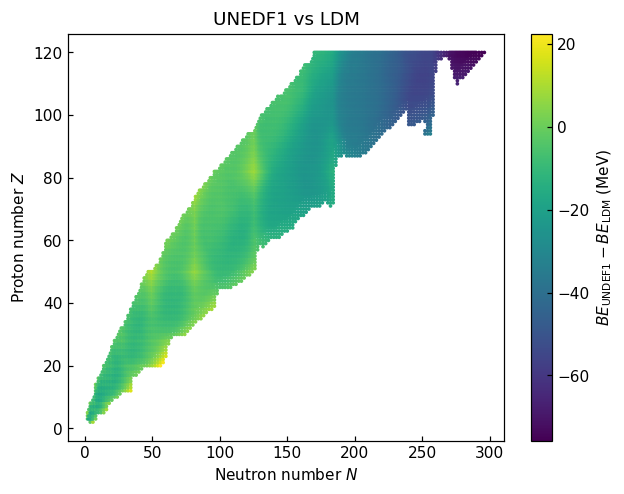

/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wp = wp.apply(lambda t: t[t['N']==t['N'].max()])
/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wp = wp.apply(lambda t: t[t['N']==t['N'].max()])


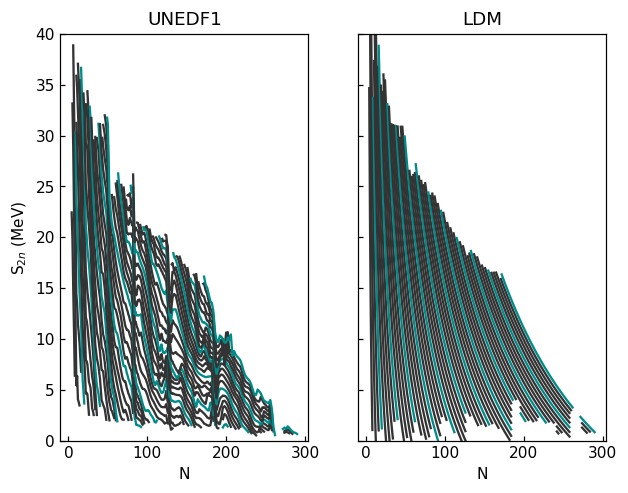

/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:113: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  stable_nuclei = pd.read_csv(infileth, usecols=(0,1),
/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:127: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(stable_nuclei['N'], stable_nuclei['Z'], s=1, marker='o', c='k', label='stable nuclei', cmap='viridis_r')


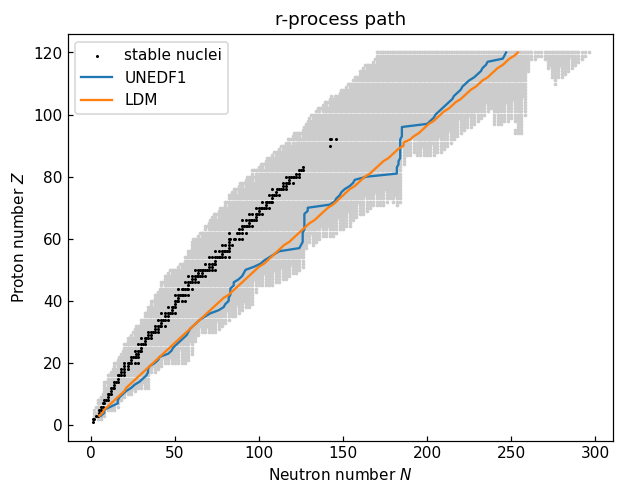

In [7]:
#
# File containing theoretical masses
#
infileth = open(data_path("UNEDF1_masses.dat"),'r')

#
# Read the theoretical data with Pandas
#
Masses_th = pd.read_csv(infileth, usecols=(1,2,3,0,4),
              names=('Element', 'Z', 'N', 'A', 'Ebinding'),
              header=1, delim_whitespace=True,
              index_col=False)

Masses_th['Ebinding'] *= -1.0

#
# Let's make a copy of the theoretical dataframe and use it to compute our LDM
#
Masses_y = Masses_th.copy()

A = Masses_y['A']
Z = Masses_y['Z']
N = Masses_y['N']

#
# Set your LDM parameters
#
a_vo = clf.coef_[1] #volume
a_su = clf.coef_[2] #surface 
a_co = clf.coef_[3] #Coulomb
a_sy = clf.coef_[4] #asymetry

#
# Compute LDM binding energies and residuals 
#
Masses_y['Eapprox'] = a_vo*A + a_su*A**(2./3.) + a_co*Z**2*A**(-1.0/3.0) + a_sy*(N-Z)**2/A  
Masses_y['Residuals'] = Masses_y['Ebinding'] - Masses_y['Eapprox']

#
# Compute S1n and S2n
#
Masses_y = get_Sn(Masses_y)
#display(Masses_y)

#
# Generate a plot comparing the experimental with the fitted values
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'Neutron number $N$')
ax.set_ylabel(r'Proton number $Z$')
plt.title('UNEDF1 vs LDM')
plt.scatter(Masses_y['N'], Masses_y['Z'], s=2, marker='o', c=Masses_y['Residuals'])
plt.colorbar(label=r'$BE_\mathrm{UNDEF1} - BE_\mathrm{LDM}$ (MeV)')
save_fig("UNEDF1vsLDM")
plt.show()

#
# Statistics
#
# The mean squared error                               
#print("Root-mean-square error: %.2f MeV" % np.sqrt(mean_squared_error(Masses_y['Ebinding'], Masses_y['Eapprox'])))
# Mean absolute error                                                           
#print('Mean absolute error: %.2f MeV' % mean_absolute_error(Masses_y['Ebinding'], Masses_y['Eapprox']))

def find_wp(masses_df, s2n, s2n_of_wp=4.0):
    """
    Let's define a function to find the waiting points in a given mass table
    Due to odd-even staggering, it is easier to work with S_2n rather than S_n
    """
    wp = masses_df[masses_df[s2n] >= s2n_of_wp][['Z', 'N', s2n]]
    wp = wp.groupby('Z')
    wp = wp.apply(lambda t: t[t['N']==t['N'].max()])
    #wp = masses_df[['Z', 'N', s2n]].copy()
    #wp['wp_lim'] = abs(wp[s2n] - s2n_of_wp)  
    #wp = wp.groupby('Z')
    #wp = wp.apply(lambda t: t[t['wp_lim']==t['wp_lim'].min()])
    return wp

unedf_wp = find_wp(Masses_y, 'S2n')
ldm_wp = find_wp(Masses_y, 'S2n_app')

#
# Plot the 2-neutron separation energies from AME and your LDM
#
fig, axv = plt.subplots(1, 2, sharex=True, sharey=True, dpi=110)
for i in Masses_y['Z'].unique():
    masses_iso = Masses_y.loc[Masses_y['Z'] == i]
    if i%10 == 0:
        color = 'darkcyan'
    else:
        color = '0.2'
    if i%2 == 0:
        axv[0].plot(masses_iso['N'], masses_iso['S2n'], '-', c=color)
        axv[1].plot(masses_iso['N'], masses_iso['S2n_app'], '-', c=color)

#axv[0].plot(unedf_wp['N'], unedf_wp['S2n'], 'o', ms=1, c='orange')
#axv[1].plot(ldm_wp['N'], ldm_wp['S2n_app'], 'o', ms=1, c='orange')

plt.ylim(0, 40)
axv[0].set_xlabel('N')
axv[1].set_xlabel('N')
axv[0].set_ylabel('S$_{2n}$ (MeV)')
axv[0].set_title('UNEDF1')
axv[1].set_title('LDM')
plt.show()

#
# Read stable nuclei datafile
#
infileth = open(data_path("stable_nz.dat"),'r')


stable_nuclei = pd.read_csv(infileth, usecols=(0,1),
              names=('N', 'Z'),
              header=1, delim_whitespace=True,
              index_col=False)


#
# Generate a plot comparing the r-process paths obtained in the two models
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'Neutron number $N$')
ax.set_ylabel(r'Proton number $Z$')
plt.title('r-process path')
plt.scatter(Masses_y['N'], Masses_y['Z'], s=2, marker='o', c='0.8')
plt.scatter(stable_nuclei['N'], stable_nuclei['Z'], s=1, marker='o', c='k', label='stable nuclei', cmap='viridis_r')
plt.plot(unedf_wp['N'], unedf_wp['Z'], label='UNEDF1')
plt.plot(ldm_wp['N'], ldm_wp['Z'], label='LDM')
plt.legend()
save_fig("rppath")
plt.show()

<font color=red>
    
##  Questionnaire
    
 - What is the main difference between the r-process path predicted by UNEDF1 and the LDM?
 
 - Knowing that the abundance of a particular nucleus is determined by its beta decay rate and that the beta decay half-live increases for nuclei closer to the valley of stability. Can you guess what will be the impact of shell closure on the r-process abundances?
    
 - [Optional] In the code above, change the values of the LDM coefficients and study the changes in the r-process path. *Recomend to copy the variables in the code and comment out the original to easily revert back the the calulated coefficients.
    
</font>

## Temperature, free neutron density and the location of the r-process path

In the previous section we studied the evolution of the abundances for different mass models. Now, we will look at the impact of the astrophysical conditions, namely the temperature $T9$ and the free neutron density $N_n$ of the environment.

We will use the expression deduced in the previous section for $S_n^0$ (actually $S_{2n}^0 = 2S_{n}^0$) to determine the waiting points and we will focus in the region of the nuclear chart around the $N=126$ shell closure.

For T= 2.0 GK and Nn = 1.0e+23 1/cm^3, the S2n of the waiting points is 9.15 Mev


/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wp = wp.apply(lambda t: t[t['N']==t['N'].max()])
/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wp = wp.apply(lambda t: t[t['N']==t['N'].max()])


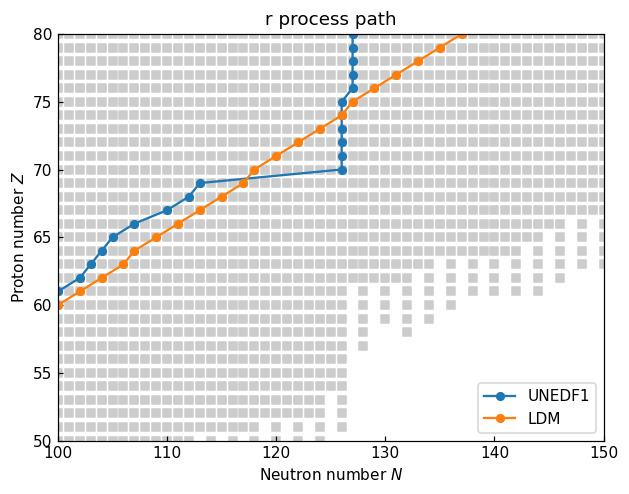

In [8]:
Nn = 1.0e23
T9 = 2
S2n_wp = 2.0 * T9 / 11.604 * (78.46 - np.log(Nn) + 1.5 * np.log(T9))

print('For T= %.1f GK and Nn = %.1e 1/cm^3, the S2n of the waiting points is %.2f Mev' % (T9, Nn, S2n_wp))

unedf_wp = find_wp(Masses_y, 'S2n', S2n_wp)
ldm_wp = find_wp(Masses_y, 'S2n_app', S2n_wp)

#
# Generate a plot comparing the r-process paths obtained in the two models
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'Neutron number $N$')
ax.set_ylabel(r'Proton number $Z$')
plt.xlim(100, 150)
plt.ylim(50, 80)
plt.title('r process path')
plt.scatter(Masses_y['N'], Masses_y['Z'], s=30, marker='s', c='0.8')
plt.plot(unedf_wp['N'], unedf_wp['Z'], '-o', ms=5, label='UNEDF1')
plt.plot(ldm_wp['N'], ldm_wp['Z'], '-o', ms=5, label='LDM')
plt.legend()
save_fig("rppath_N126")
plt.show()

For T= 2.0 GK and Nn = 1.0e+23 1/cm^3, the S2n of the waiting points is 9.15 Mev


/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wp = wp.apply(lambda t: t[t['N']==t['N'].max()])
/var/folders/zq/1xy963nd2nd6rcmqzm761ynh0000gn/T/ipykernel_88384/4039601113.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wp = wp.apply(lambda t: t[t['N']==t['N'].max()])


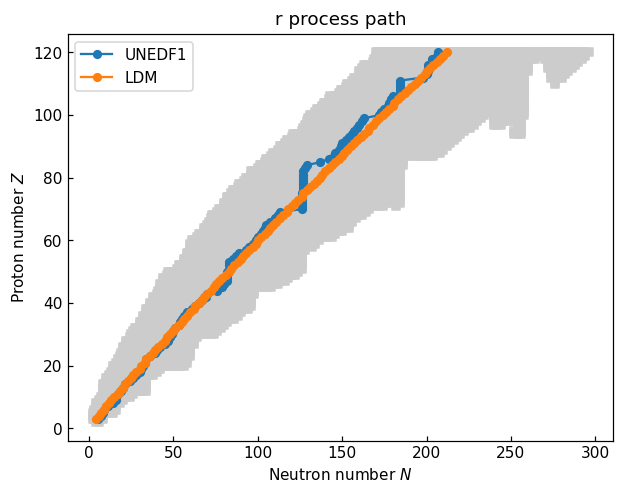

In [9]:
## uncomment to change Nn and T9 to compare r process path to the above

Nn = 1.0e23
T9 = 2
S2n_wp = 2.0 * T9 / 11.604 * (78.46 - np.log(Nn) + 1.5 * np.log(T9))

print('For T= %.1f GK and Nn = %.1e 1/cm^3, the S2n of the waiting points is %.2f Mev' % (T9, Nn, S2n_wp))

unedf_wp = find_wp(Masses_y, 'S2n', S2n_wp)
ldm_wp = find_wp(Masses_y, 'S2n_app', S2n_wp)

#
# Generate a plot comparing the r-process paths obtained in the two models
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'Neutron number $N$')
ax.set_ylabel(r'Proton number $Z$')
#plt.xlim(100, 150)
#plt.ylim(50, 80)
plt.title('r process path')
plt.scatter(Masses_y['N'], Masses_y['Z'], s=30, marker='s', c='0.8')
plt.plot(unedf_wp['N'], unedf_wp['Z'], '-o', ms=5, label='UNEDF1')
plt.plot(ldm_wp['N'], ldm_wp['Z'], '-o', ms=5, label='LDM')
plt.legend()
save_fig("rppath_N126")
plt.show()

<font color=red>
    
##  Questionnaire
    
 - Modify the `Nn` and `T9` variables in the code above and study the displacement of the r-process path. How sensitive is $S_{2n}^0$ to the astrophysical conditions? How sensitive is $S_{2n}^0$ to the astrophysical conditions? (note: try `Nn` in the range of 10^{20} to 10^{28} and `T9` from 0.1 to 5.0)
 
 - Discuss whether this calculation of the r-process path will be a good approximation at very low/high temperatures (remember that we assumed $(n,\gamma)\rightleftarrows(\gamma,n)$ equilibrium) 
    
</font>